In [1]:
!pip install keras-mdn-layer

  Created wheel for keras-mdn-layer: filename=keras_mdn_layer-0.3.0-cp37-none-any.whl size=7054 sha256=75772958134dd4102f0c692112b6722d20c641c2693afe3dd54e1969f65ab0da
  Stored in directory: /root/.cache/pip/wheels/b6/e3/ba/8fb07898b8c8e5d4c1a035add0b71629b2fbe82ee8a5f0a2c8
Successfully built keras-mdn-layer


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

In [8]:
input_parameters = [
    'Mass', 
    'Radius',
    'H2O_mass_frac', 
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "RockyExop_MDN_20210330.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_INPUT_scaler20210330.save")
output_scaler = joblib.load("MDN_OUTPUT_scaler20210330.save")

## Predict Earth (for example)

In [9]:
# EARTH
# input mass and radius for predicting must be earth units
input_array_earth = np.array(
    [
        [1], # mass
        [1], # radius
        [0.0005], # water mass fraction
    ]
)
scaled_input = input_scaler.transform(input_array_earth.T)

In [10]:
pred = model.predict(scaled_input)
# pred contains parameters for distributions, not actual points on the graph.
print(pred)
print(pred.shape)

[[ 5.45808673e-03  3.50204706e-01  7.13157952e-01  5.18759906e-01
   7.77015164e-02  2.30528474e-01  1.18889213e-02  3.45626414e-01
   7.16007531e-01  5.26015222e-01  7.91446269e-02  2.35401496e-01
  -5.14566898e-04  4.50669914e-01  6.09023869e-01  3.54491502e-01
   7.46228844e-02  2.39499077e-01 -1.77027583e-02  3.78399611e-01
   6.88814640e-01  4.79079843e-01  6.88626766e-02  2.24758998e-01
   9.42260027e-03  3.92682582e-01  6.65917635e-01  4.41299081e-01
   8.48840177e-02  2.40150973e-01  8.97774100e-03  3.98819447e-01
   6.59168661e-01  4.31402147e-01  8.49302411e-02  2.39655465e-01
   8.57794285e-03  4.04657245e-01  6.57512128e-01  4.25746232e-01
   8.06252211e-02  2.31661662e-01  5.62226772e-03  4.22981262e-01
   6.37323976e-01  3.89100373e-01  8.16166997e-02  2.44079381e-01
   1.31445527e-02  3.60407144e-01  7.00948238e-01  5.02671480e-01
   8.27987194e-02  2.31971055e-01  7.45847821e-03  3.75369430e-01
   6.81395888e-01  4.68946397e-01  8.47854018e-02  2.39219949e-01
   3.48776

In [11]:
OUTPUT_DIMS

6

In [12]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
    print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

0
1
2
3
4
5


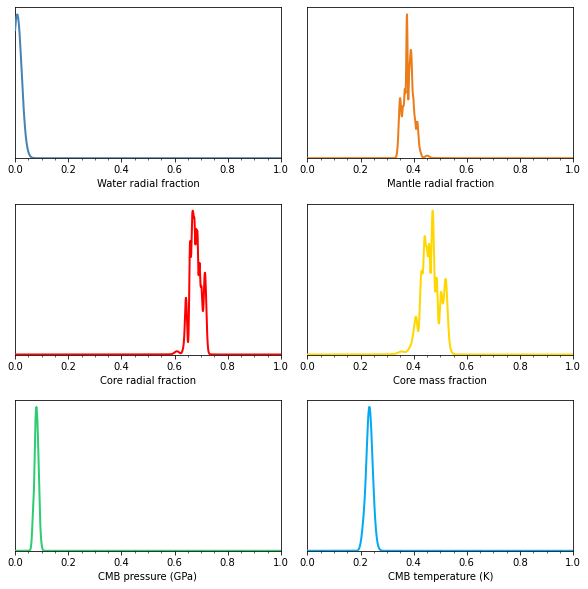

In [18]:
colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure (GPa)", 
    "CMB temperature (K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(bottom=0)
    ax.set_yticks([])
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
# plt.savefig('512EARTH-water.eps')